<a href="https://colab.research.google.com/github/mgt412/course_notebooks/blob/master/MGT412_Lecture_5_Optimization_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 5: Convex Optimization. Application: GARCH and volatility clustering

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We want to minimize a function $f\left(x_1,x_2,x_3,\dots,x_n\right)$:
$$ \min_{\textbf{x}} f\left(x_1,x_2,x_3,\dots,x_n\right). $$

All local extrema satisfy the first order condition:
$$ \frac{\partial f}{\partial x_i} =0, \forall i\in\left\{1,2,\dots,n\right\} $$


## Function maximization/minimization

> **Problem:** Find the values of $x$ and $y$ that minimize: $$ f\left(x,y\right)= \sin(x)+\frac{1}{20}x^2+\sin\left(y\right)+\frac{1}{20}y^2 $$



In [0]:
def fm(arg):
    x,y=arg
    z=np.sin(x)+1/20.0*x**2+np.sin(y)+1/20.0*y**2
    # print "%8.4f %8.4f %8.4f" % (x,y,z)
    return z

Text(0.5, 0, 'f(x,y)')

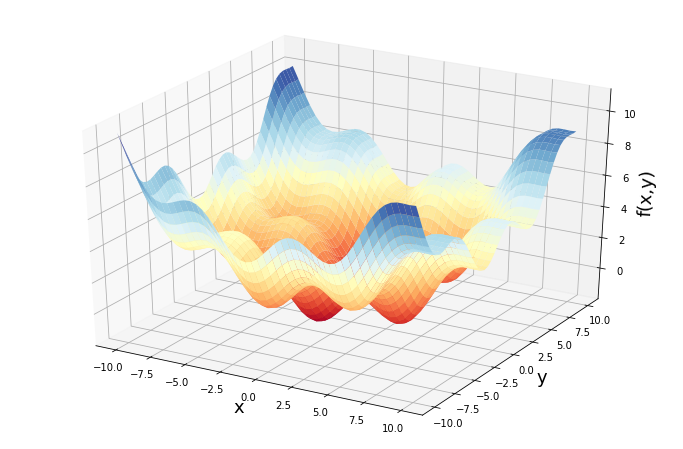

In [8]:
# Plot the function
x=np.linspace(-10,10,50)
y=np.linspace(-10,10,50)

X,Y=np.meshgrid(x,y)

Z=fm(X,Y)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

fig=plt.figure(figsize=(12,8))
ax=fig.gca(projection='3d')

surf=ax.plot_surface(X,Y,Z,cmap=mpl.cm.RdYlBu)
ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('y',fontsize=18)
ax.set_zlabel('f(x,y)',fontsize=18)

### Brute force optimization (grid search)

In [0]:
import scipy.optimize as spo
search_area=(-10,10.01,0.1) # define a grid: from -10 to 10, in 0.1 increments

def fm1(arg):
    x,y=arg
    z=np.sin(x)+1/20.0*x**2+np.sin(y)+1/20.0*y**2
    print ("%8.4f %8.4f %8.4f" %(x,y,z))
    return z

min_1=spo.brute(fm1, (search_area,search_area), finish=None)

In [15]:
min_1

array([-1.4, -1.4])

**Question:**  How can we improve the accuracy? What is the drawback? 

The brute force method, while limited, can serve to provide starting
values for more sophisticated algorithms.

One such function, working with numerical derivatives, is `fmin`.

### Optimization with `fmin`

General structure:


```
[xopt, fopt]=spo.fmin(function, start_values, xtol=, ftol=, maxiter=, maxfun=)
```
1. `xtol` : Relative error in argument acceptable for convergence.
2. `ftol`: Relative error in function acceptable for convergence.
3. `maxiter` : Maximum number of iterations to perform.
4. `maxfun` : Maximum number of function evaluations to make.

We can use the global optimization results as starting values.

In [18]:
min_2=spo.fmin(fm, min_1, xtol=0.001, ftol=0.001)
min_2

Optimization terminated successfully.
         Current function value: -1.775726
         Iterations: 16
         Function evaluations: 32


array([-1.42743423, -1.42786531])

#### Caveats:

1. Local optimization routines can get stuck in local extrema...
2. ... or they may never converge.
3. It is a good idea to perform a global optimization first to pinpoint the neighbourhood of global minimum.
4. What happens if we start `fmin` with (2; 2) as starting values?


In [19]:
# Sensitivity to starting values
min_3=spo.fmin(fm, [2,2], xtol=0.001, ftol=0.001)
min_3

Optimization terminated successfully.
         Current function value: 0.015826
         Iterations: 37
         Function evaluations: 70


array([4.27113587, 4.27123862])

### Constrained optimization

Most of the time, we look for optimal values of a function under a
set of constraints.

**Exercise**

There are two securities, $A$ and $B$: Both cost 10 today. Tomorrow
there are two equally likely states of the world: $g$ or $b$. In state $g$,
$A = 15$ and $B = 5$. In state $b$, $A = 5$ and $B = 12$. Assume an
investor has 100 units of cash today and utility $u(w)=\sqrt{w}$. What
is his optimal investment?


> ** Formalization **

$$\max_{a,b} \mathbb{E}u\left(w_1\right) = \max_{a,b} \frac{1}{2} \sqrt{15a+5b}+\frac{1}{2}\sqrt{5a+12b} $$

subject to:

$$ 10a+10b\leq 100. $$

In [22]:
# First, define the function. NOTE: we want to maximize expected utility, or
# minimize minus expected utility.
def ExpU(arg):
    s,b=arg
    return -(0.5*np.sqrt(s*15+b*5)+0.5*np.sqrt(s*5+b*12))

  
# Second, define the constraint as a dict variable and an implicit function. 
# Inequality sign is always implicitly >=0.
cons=({'type':'ineq', 'fun': lambda x: 100-x[0]*10-x[1]*10})

# Third, choose starting values
startval=[5,5]

# Fourth, run the minimize function.
result=spo.minimize(ExpU, startval, method='SLSQP', constraints=cons)
result

     fun: -9.700883611487832
     jac: array([-0.48508096, -0.48489535])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([8.02547122, 1.97452878])

#### Notes

1. `method` stands for optimization algorithm. SLSQP (Sequential Least SQuares Programming) allows one to introduce constraints.
2.  One can specify Jacobian (`jac`, first derivatives) or Hessian matrix (`hess`, second derivatives) directly.
3. In addition, bounds for the argument can be specified by `bounds`.


#### Output methods

1. `result.fun` returns the optimum function values.
2. `result.x` returns the arguments corresponding to the
optimum.
3. `result.success` returns True if optimization complete.

## GARCH model for stock returns

Let's import S&P/TSX price data from July 2000 to July 2019 and study the pattern of returns.

In [104]:
from pandas import *
url_data="https://github.com/mgt412/course_notebooks/blob/master/Datasets/L5_SPTSX_Prices.xlsx?raw=true"
SPTSX=read_excel(url_data)
SPTSX[42:47] # example missing data

,Date,SPTSX
42,2000-08-30,11173.599609
43,2000-08-31,11247.900391
44,2000-09-01,11388.799805
45,2000-09-04,NaN
46,2000-09-05,11328.200195


In [105]:
# clean the data
SPTSX=SPTSX.replace("null",np.nan)
SPTSX=SPTSX.fillna(method='ffill')

SPTSX[42:47]

,Date,SPTSX
42,2000-08-30,11173.599609
43,2000-08-31,11247.900391
44,2000-09-01,11388.799805
45,2000-09-04,11388.799805
46,2000-09-05,11328.200195


In [107]:
# compute logarithmic returns
SPTSX['Return']=SPTSX['SPTSX'].map(np.log)-SPTSX['SPTSX'].map(np.log).shift(1)
SPTSX.head()

,Date,SPTSX,Return
0,2000-07-03,10195.500000,NaN
1,2000-07-04,10301.400391,0.010333
2,2000-07-05,10323.799805,0.002172
3,2000-07-06,10242.599609,-0.007896
4,2000-07-07,10380.299805,0.013354


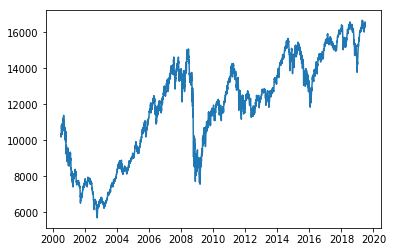

In [108]:
plt.plot(SPTSX['Date'], SPTSX['SPTSX']) # a plot of the index 

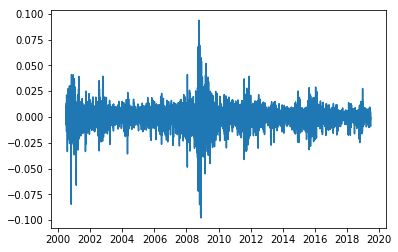

In [109]:
plt.plot(SPTSX['Date'], SPTSX['Return']) # a plot of the returns
# notice volatility clustering, especially in the crisis

In [0]:
returns=np.asarray(SPTSX['Return'][1:].tolist()) 
N=len(returns)# number of observations

The **Generalised Autoregressive Conditional Heteroskedasticity**
model, or GARCH:
1. Allows the volatility of returns to be time-dependent, following
a AR process.
2. Therefore, it is a suitable model to account for the empirical
observation of volatility clustering
3. Clustering: Periods of high volatility are likely to be followed
also by periods of high volatility.
4. An important note is that the volatility is non-stochastic!
5. Estimation of GARCH is done by maximum likelihood.

Let stock (index) returns be given by:
\begin{equation}
r_t=\mu+\epsilon_t,\text{ where } \epsilon_t \sim \mathcal{N}\left(0,\sigma^2_t\right)
\end{equation}

The variance dynamics is:
\begin{equation}
\sigma^2_{t+1}=\omega+\alpha \epsilon^2_t+\delta  \sigma^2_{t}
\end{equation}

For the model to remain stationary (variance does not explode) we require:
\begin{equation}
\alpha+\delta<1
\end{equation}

There are four parameters to estimate: $\mu$, $\omega$, $\alpha$, $\delta$.

> **Long run volatility.**  In the long run, the expected volatility $\bar{\sigma}^2$ should respect:
\begin{equation}
\bar{\sigma}^2=\omega+\alpha \mathbb{E}\epsilon^2_t+\delta \bar{\sigma}^2 \rightarrow \bar{\sigma}^2 = \frac{\omega}{1-\alpha-\delta}
\end{equation}
We will use this value to "start off" the volatility process.

### Function to return volatilities (volatility "filtering")

Let $N$ be the number of observations. 

Let us define a function that, given parameter values, returns the time-series of volatilities:

In [0]:
def vols(mu, omega, delta, alpha, errors, N):
    Sigmas2=np.zeros(N) # initialize volatility vector with zeros
    Sigmas2[0]=omega/(1-alpha-delta) # we start from the unconditional (long-run) volatility
    for i in range(1,N): 
        # fill out the volatility vector from first to last observations
        Sigmas2[i]=omega+alpha*errors[i-1]**2+delta*Sigmas2[i-1] 
    return Sigmas2

### Probability distribution

Given the model parameters, $\mu$ (mean return), $\omega$, $\alpha$, $\delta$, and $\sigma^2_{t-1}$, the "noise return" $\epsilon_t$ is normally distributed with mean zero and variance $\sigma^2_t$. 

The probability of observing a given noise return $\epsilon_t$  in the data, for time $t$ and given model parameter values, is given by the density function of a normal distribution:
$$ f\left(\epsilon_t\right)=\frac{1}{\sqrt{2\pi\sigma_t^2}} \times \exp \left(-\frac{1}{2} \frac{\epsilon_t^{2}}{\sigma_t^{2}}\right) $$.

It is numerically easier to work with sums than products, so we take the log of $f$ and obtain a **log-likelihood** function (remember that $\log(xy)=\log x+ \log y$)

The likelihood function for normally distributed errors:

\begin{align*}
\mathcal{L}\left(\epsilon_t,\sigma_t\right)=-\frac{1}{2}\ln2\pi-\frac{1}{2}\ln\sigma_t^{2}-\frac{1}{2}\frac{\epsilon_t^{2}}{\sigma_t^{2}}
\end{align*}

> **GOAL**: we want to choose the model parameters in such a way that we **maximize** the joint probability of observing all our data points at the same time (that is, we solve an optimization problem). The method is known as *maximum likelihood*. We need to maximize:
> $$ \max_{\mu,\omega,\alpha,\delta} f(\epsilon_1) \times f(\epsilon_2) \times f(\epsilon_3) \dots \times f(\epsilon_N) $$
> or, equivalently,
> $$ \max_{\mu,\omega,\alpha,\delta} \mathcal{L}(\epsilon_1) + \mathcal{L}(\epsilon_2) + \mathcal{L}(\epsilon_3) \dots + \mathcal{L}(\epsilon_N) $$

In [0]:
# input: vector of parameters, number of observations
# output: log-likelihood for all observations.
# This will be our objective function

def LogLikelihood(theta,N):
    LL=np.zeros(N) # vector of log-likelihoods for each observation
    
    # individual parameters
    mu, omega, delta, alpha=theta
    
    errors=returns-mu # return errors
    
    # generate volatilities given parameters
    Sigmas=vols(mu,omega,delta,alpha,errors,N)

    if Sigmas.min()<0: # all volatilities should be positive
        return 0
    
    # add likelihoods
    for i in range(0,N):
        LL[i]=-0.5*np.log(2*np.pi)-0.5*np.log(Sigmas[i])-(errors[i])**2/(2*Sigmas[i])

    # average log-likelihood
    #print theta, LL.mean()
    return -LL.mean()

### Initialize parameters and conditions

In [0]:
zeroplus=10**-5
oneminus=1-zeroplus

theta=np.zeros(4)
theta[0]=returns.mean() # mu starting value
theta[2]=0.9 # delta
theta[3]=0.05 # alpha
theta[1]=returns.std()*(1-theta[2]-theta[3]) # omega

bnds=((-np.inf,np.inf),(zeroplus,np.inf),(zeroplus,oneminus),(zeroplus,oneminus)) # bounds
cons=({'type':'ineq', 'fun':lambda x: oneminus-x[2]-x[3]}) # volatility is stationary

In [114]:
theta

array([9.85349979e-05, 5.26150916e-04, 9.00000000e-01, 5.00000000e-02])

### Maximize likelihood

In [115]:
import scipy.optimize as sco
opt=sco.minimize(lambda x: LogLikelihood(x,N), theta, method='SLSQP', bounds=bnds, constraints=cons)
# save estimates
[mu,omega,delta,alpha]=opt['x']
errors=returns-mu
SPTSX_revised=SPTSX[1:] # eliminate first observation (no return)
SPTSX_revised['Volatility']=vols(mu, omega, delta, alpha, errors, N)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Optimization results:

In [93]:
opt

     fun: -3.350195714182226
     jac: array([-2.52023637e-02,  3.12073468e+03,  3.96072865e-05,  1.51652098e-03])
 message: 'Optimization terminated successfully.'
    nfev: 153
     nit: 23
    njev: 22
  status: 0
 success: True
       x: array([4.27010531e-04, 1.00000000e-05, 6.89967797e-01, 2.09180224e-01])

(array([-0.0005,  0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,
         0.003 ,  0.0035]), <a list of 9 Text yticklabel objects>)

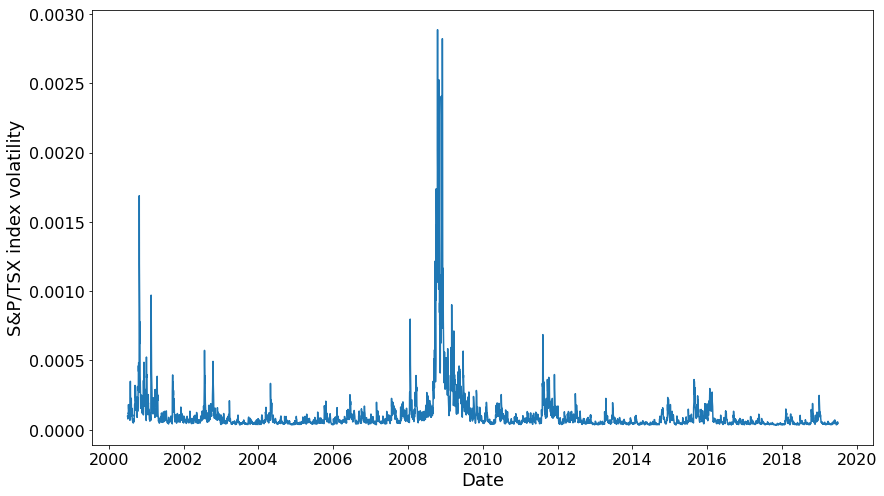

In [119]:
plt.figure(figsize=(14,8))
#plt.plot(dataG['Date'].apply(lambda x: dt.datetime.strptime(x,"%d/%m/%y")), dataG['Volatility'], lw=1.5, ls='-')
plt.plot(SPTSX_revised['Date'], SPTSX_revised['Volatility'], lw=1.5, ls='-')
plt.xlabel('Date', fontsize=18)
plt.ylabel('S&P/TSX index volatility', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Symbolic Mathematics

In [0]:
import sympy as sy

x=sy.Symbol('x')
y=sy.Symbol('y')

### Simplify functions (group terms)

$$ x^2 + 3 + 0.5 x^2 + \frac{3}{2} = 1.5 x^2+4.5 $$

In [26]:
f=x**2+3+0.5*x**2+3/2
sy.simplify(f)

1.5*x**2 + 4.5

### Solving equations

In [0]:
sy.solve(x**2-4), sy.solve(x**2-y**2), sy.solve(x**3+3*x**2+3*x+1), sy.solve({x-y-1,x+y-2})

([-2, 2], [{x: -y}, {x: y}], [-1], {x: 3/2, y: 1/2})

### Symbolic integration

In [0]:
sy.integrate(sy.log(x)+sy.sin(x))

x*log(x) - x - cos(x)

### Symbolic differentiation

In [0]:
f=x**3+x-sy.exp(y)
sy.diff(f,x), sy.diff(f,y)

(3*x**2 + 1, -exp(y))

### Solve a first order condition

In [0]:
x_zero=sy.solve(sy.diff(f,x))
x_zero

[-sqrt(3)*I/3, sqrt(3)*I/3]

### Numerically evaluate symbolic functions

In [0]:
f.subs({x:2,y:0}).evalf()

9.00000000000000

## Application (lab exercise)

Optimize the function
$$ g\left(x\right)=\frac{x^2}{2}+x\left(y-1\right)+y $$
both numerically and solving the first order conditions in *sympy*.